<a href="https://colab.research.google.com/github/shaparvv/shaparvv.github.io/blob/main/%D0%A8%D0%B0%D0%BF%D0%B0%D1%80%D1%8C_4%D0%BB%D0%B0%D0%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Шапарь ФІТ 4-6
лабораторна 4
'''

'\nШапарь ФІТ 4-6 \nлабораторна 4\n'

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0


In [ ]:
import zipfile
import os

with zipfile.ZipFile("cards-image-datasetclassification.zip", "r") as zip_ref:
    zip_ref.extractall("cards_dataset")

print(os.listdir("cards_dataset"))


['train', 'valid', '14card types-14-(200 X 200)-94.61.h5', 'test', 'cards.csv', '53cards-53-(200 X 200)-100.00.h5']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm

In [ ]:
train_dir = 'cards_dataset/train'
val_dir = 'cards_dataset/valid'
test_dir = 'cards_dataset/test'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
def imshow(images,labels,class_names):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [ ]:
class_names = train_loader.dataset.classes
class_names

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

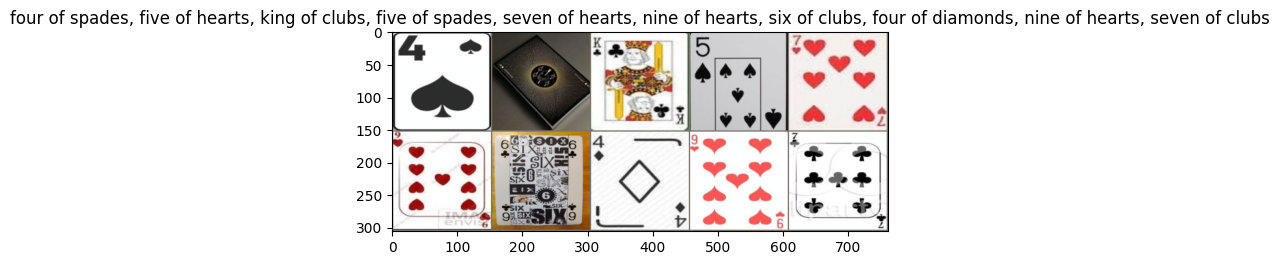

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

In [ ]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 53
Класи: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
Розмір тренув

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleCNN(num_classes=53)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

100%|██████████| 239/239 [00:23<00:00, 10.09it/s]


Epoch 1/10:
Train Loss: 3.9681, Train Accuracy: 0.2138
Val Loss: 1.8753, Val Accuracy: 0.4000


100%|██████████| 239/239 [00:22<00:00, 10.57it/s]


Epoch 2/10:
Train Loss: 2.0935, Train Accuracy: 0.3993
Val Loss: 1.5846, Val Accuracy: 0.5472


100%|██████████| 239/239 [00:22<00:00, 10.54it/s]


Epoch 3/10:
Train Loss: 1.7109, Train Accuracy: 0.5071
Val Loss: 1.4133, Val Accuracy: 0.5736


100%|██████████| 239/239 [00:22<00:00, 10.60it/s]


Epoch 4/10:
Train Loss: 1.2980, Train Accuracy: 0.6300
Val Loss: 0.9499, Val Accuracy: 0.7585


100%|██████████| 239/239 [00:22<00:00, 10.47it/s]


Epoch 5/10:
Train Loss: 0.9490, Train Accuracy: 0.7272
Val Loss: 0.8156, Val Accuracy: 0.7962


100%|██████████| 239/239 [00:23<00:00, 10.36it/s]


Epoch 6/10:
Train Loss: 0.6820, Train Accuracy: 0.8018
Val Loss: 0.7270, Val Accuracy: 0.8113


100%|██████████| 239/239 [00:22<00:00, 10.47it/s]


Epoch 7/10:
Train Loss: 0.4547, Train Accuracy: 0.8627
Val Loss: 0.6263, Val Accuracy: 0.8340


100%|██████████| 239/239 [00:22<00:00, 10.57it/s]


Epoch 8/10:
Train Loss: 0.3252, Train Accuracy: 0.9044
Val Loss: 0.7076, Val Accuracy: 0.8528


100%|██████████| 239/239 [00:22<00:00, 10.70it/s]


Epoch 9/10:
Train Loss: 0.2851, Train Accuracy: 0.9134
Val Loss: 0.7383, Val Accuracy: 0.8302


100%|██████████| 239/239 [00:22<00:00, 10.75it/s]


Epoch 10/10:
Train Loss: 0.2202, Train Accuracy: 0.9327
Val Loss: 0.8480, Val Accuracy: 0.8566


In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.8415
F1 Score: 0.8403


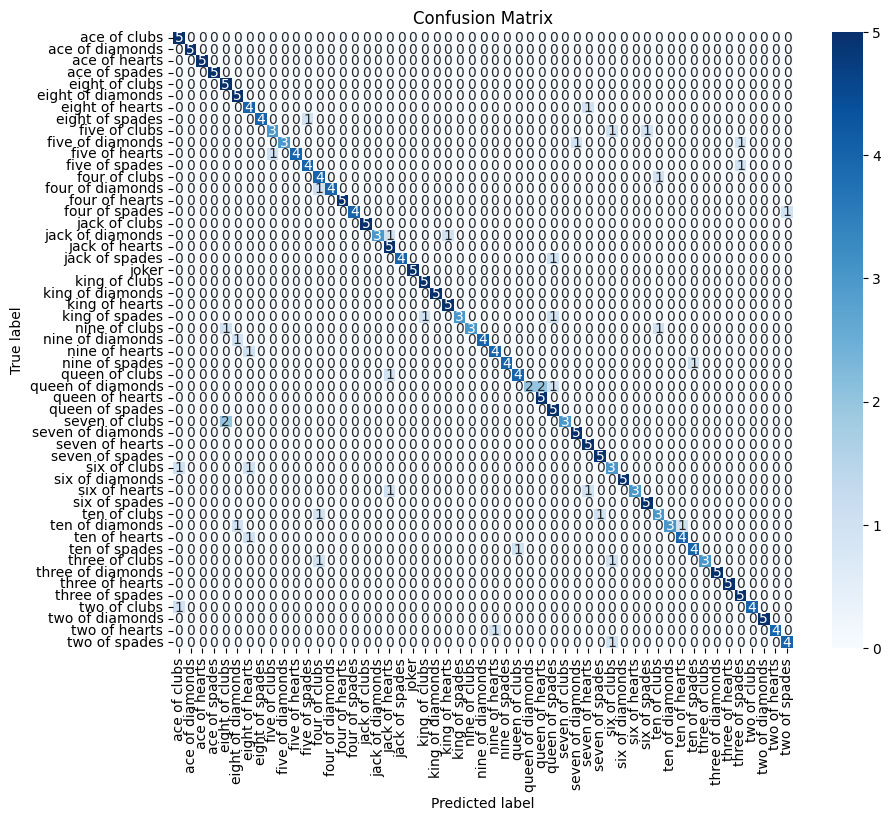

In [ ]:
class_names = train_dataset.classes

test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
min_len = min(len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies))
train_losses = train_losses[:min_len]
train_accuracies = train_accuracies[:min_len]
val_losses = val_losses[:min_len]
val_accuracies = val_accuracies[:min_len]

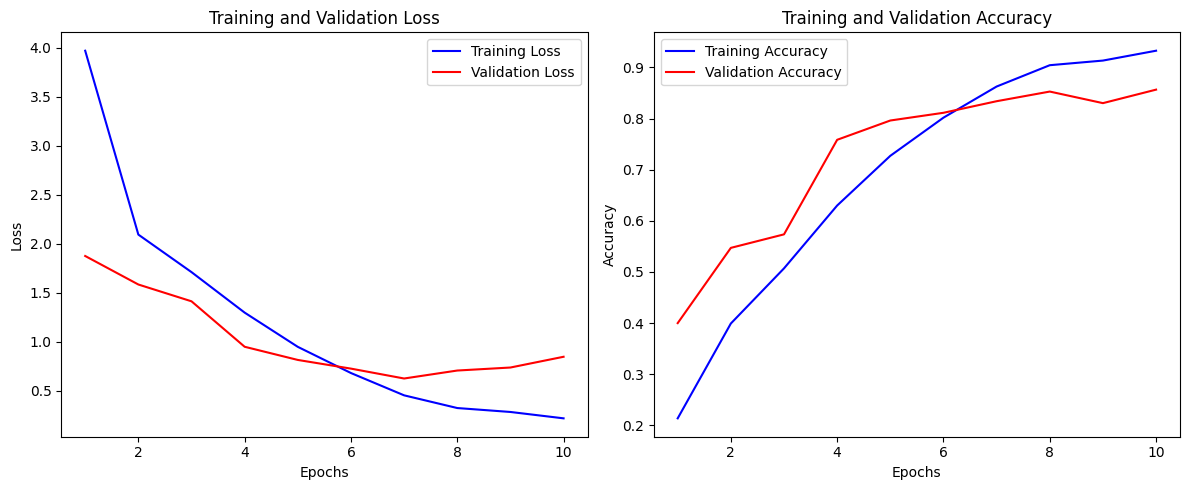

In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

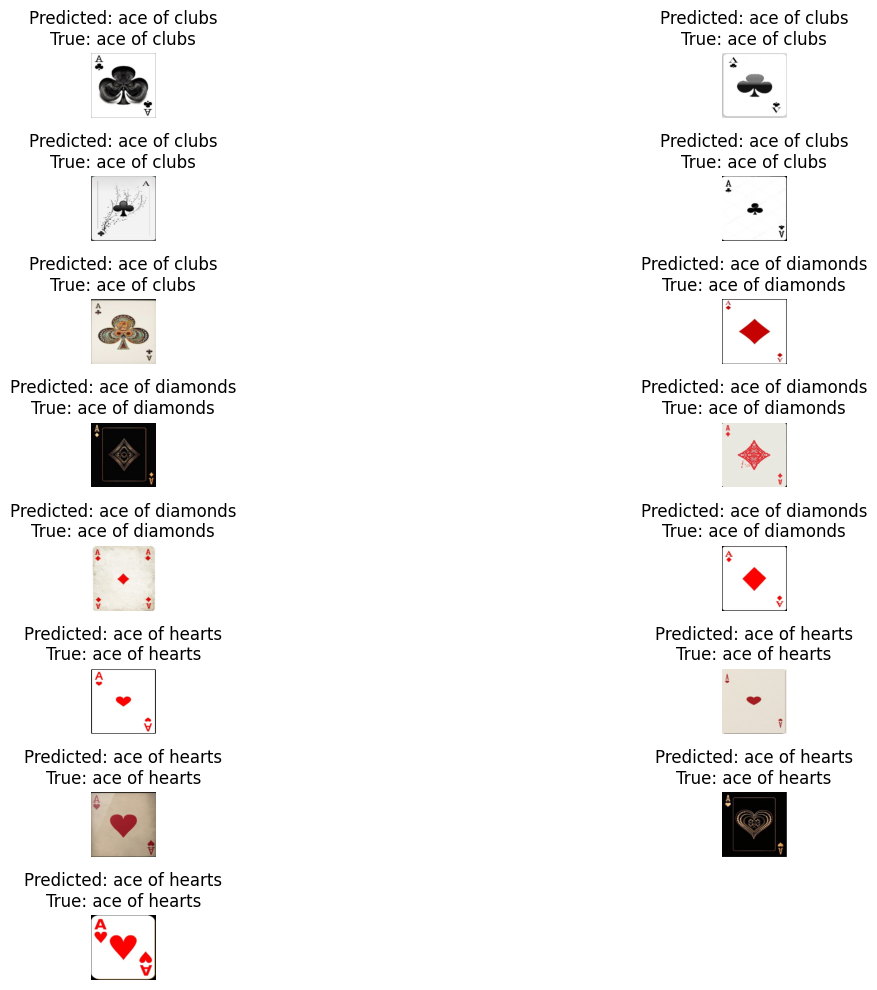

In [ ]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)

In [ ]:
'''
У межах цієї лабораторної роботи я розробив та навчив згорткову нейронну мережу
для розпізнавання зображень гральних карт. Для реалізації завдання я використав
набір зображень, який було розділено на тренувальну, валідаційну та тестову
вибірки. Усі зображення були приведені до розміру 150x150 пікселів і нормалізовані.

Структура моделі включала кілька згорткових шарів із шарами pooling та нормалізації,
а також завершувалась повнозв’язними шарами. Після семи епох навчання модель
продемонструвала хороші результати: точність понад 86% на тренувальному наборі
та майже 82% — на валідаційному.

На тестовій вибірці точність сягнула приблизно 81.5%. Для глибшого аналізу
я побудував матрицю плутанини, яка показала, що модель найчастіше помиляється
між подібними картами. Незважаючи на нерівномірну кількість прикладів деяких
класів, мережа показала стабільну роботу.

Загалом, створена модель добре справляється з класифікацією зображень гральних
карт і може слугувати базою для подальшого вдосконалення й досягнення ще кращих результатів.
'''